# Data Exploration Project - Pumps

## Business Understanding

Daten über verschiedene Brunnen in einem afrikanischen Land.

**Können wir vorhersagen welche Brunnen defekt, wartungsbedürftig oder voll funktional sind?**

## Data Understanding

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from category_encoders import TargetEncoder, BinaryEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

Einlesen der Trainings- und Testdaten.

In [4]:
df_pump_train = pd.read_csv('pump_train.csv')
df_pump_test = pd.read_csv('pump_test.csv')

### Data Dictionary
| Variable | Beschreibung |
| -------- | ------------ |
| amount_tsh | Total static head (amount water available to waterpoint) |
| date_recorded | The date the row was entered |
| funder | Who funded the well |
| gps_height | Altitude of the well |
| installer | Organization that installed the well |
| longitude | GPS coordinate |
| latitude | GPS coordinate |
| wpt_name | Name of the waterpoint if there is one |
| num_private | ? |
| basin | Geographic water basin |
| subvillage | Geographic location |
| region | Geographic location |
| region_code | Geographic location (coded) |
| district_code | Geographic location (coded) |
| lga | Geographic location |
| ward | Geographic location |
| population | Population around the well |
| public_meeting | True/False |
| recorded_by | Group entering this row of data 
| scheme_management | Who operates the waterpoint |
| scheme_name | Who operates the waterpoint |
| permit | If the waterpoint is permitted |
| construction_year | Year the waterpoint was constructed 
| extraction_type | The kind of extraction the waterpoint uses 
| extraction_type_group | The kind of extraction the waterpoint uses |
| extraction_type_class | The kind of extraction the waterpoint uses 
| management | How the waterpoint is managed |
| management_group | How the waterpoint is managed |
| payment | What the water costs |
| payment_type | What the water costs |
| water_quality | The quality of the water |
| quality_group | The quality of the water |
| quantity | The quantity of water |
| quantity_group | The quantity of water |
| source | The source of the water |
| source_type | The source of the water |
| source_class | The source of the water |
| waterpoint_type | The kind of waterpoint |
| waterpoint_type_group | The kind of waterpoint |
| status_group | functional or non-functional or functional needs repair |

### Data Analysis

## Data Preparation

## Pipeline

[Categoric Encoder Package ->](https://contrib.scikit-learn.org/category_encoders/index.html)

In [5]:
class YesNoEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, add_column = True):
        self.add_column = add_column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.add_column:
            has_name = np.where(X['wpt_name']!= 'none', 1, 0)
            Xcopy = X
            Xcopy['wpt_name'] = has_name
        return Xcopy

In [6]:
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, fill_value="other"):
        self.fill_value = fill_value
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self.fill_value if str(x)==str(np.nan) else x for x in X]).reshape(-1,1)

In [7]:
scheme_pipeline = Pipeline([
('imputer', MyImputer(fill_value="other")),
('one_hot', OneHotEncoder())
])

In [8]:
class YearAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)
        

In [9]:
year_pipeline = Pipeline([
    ("add_year", YearAdder()),
    #("ord_enc", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ("scale", MinMaxScaler())
])

In [10]:
class AmountPerCapitaAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        date_column = pd.Series(X)
        return np.array(pd.DatetimeIndex(date_column).year).reshape(-1,1)

In [11]:
df_train = df_pump_train.copy()

# add new target variables

df_train["t_functional"] = df_train["status_group"].apply(lambda x: 0 if x=="non functional" else 1)
df_train["t_needs_rep"] = df_train["status_group"].apply(lambda x: 1 if x=="functional needs repair" else 0)

# drop outliers
df_train = df_train.drop(df_train[df_train.longitude == 0].index)

# add new feature manually
df_train["amount_per_capita"] = df_train.apply(lambda x: x["amount_tsh"]/x["population"] if x["population"] != 0 else 0, axis=1)

# transform dtypes manually
df_train["district_code"] = df_train["district_code"].astype("category")
df_train["region_code"] = df_train["region_code"].astype("category")

y_train = df_train.loc[:,'status_group']
le = LabelEncoder()
y_train = le.fit_transform(y_train)

y_train_f = df_train["t_functional"]
le = LabelEncoder()
y_train_f = le.fit_transform(y_train_f)

y_train_r = df_train["t_needs_rep"]

col_imp = Pipeline([
    ('simp_inputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

target_enc_pipe = Pipeline([
    ('target_enc', TargetEncoder()),
    ('min_max', MinMaxScaler())
])

col_trans = ColumnTransformer(transformers=[
    ['col_imp', col_imp, ['funder', 'installer', 'subvillage']],
    ['target_enc', target_enc_pipe, ['lga', 'ward', 'management']],
    ['oh_enc', OneHotEncoder(), ['basin', 'payment','water_quality', 'quantity','source','waterpoint_type', 'extraction_type_class']],
    ['bin_enc', BinaryEncoder(), ['region', 'region_code', 'district_code']], # warum alle 3 ?
    ['cust_trans', YesNoEncoder(), ['wpt_name']],
    ["num", MinMaxScaler(), ["amount_tsh", "population", "amount_per_capita", 'gps_height', 'longitude', 'latitude']],
    ["scheme", scheme_pipeline, "scheme_management"],
    ["year",  year_pipeline, "date_recorded"]
], remainder='drop')

c:\Users\LordFabi\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\LordFabi\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [12]:
X_train_f = col_trans.fit_transform(X=df_train, y=y_train_f)

c:\Users\LordFabi\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\LordFabi\anaconda3\lib\site-packages\category_encoders\target_encoder.py:97: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
c:\Users\LordFabi\anaconda3\lib\site-packages\category_encoders\target_encoder.py:92: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
c:\Users\LordFabi\anaconda3\lib\site-packages\category_encoders

Modelling for Functional vs non Functional

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from tqdm import tqdm

from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

c:\Users\LordFabi\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [14]:
df_results = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])


Logistische Regression

In [15]:
lr_cf = LogisticRegression(solver="sag", max_iter=1000, n_jobs= -1, class_weight='balanced')
lr_cf.fit(X_train_f, y_train_f)
y_pred_f = lr_cf.predict_log_proba(X_train_f)[:,1]
auc_train_f = roc_auc_score(y_train_f, y_pred_f)
cv_res = cross_validate(estimator=lr_cf, X=X_train_f, y=y_train_f, cv=5, scoring='roc_auc_ovr', n_jobs= -1)
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [lr_cf, auc_train_f, auc_cv]

Decision Tree

{'fit_time': array([1.42530227, 1.55041409, 1.51838517, 1.47634697, 1.55041409]), 'score_time': array([0.01901603, 0.02302527, 0.01101089, 0.02101922, 0.02102065]), 'test_score': array([0.81983557, 0.820885  , 0.81671936, 0.81612346, 0.81845857])}


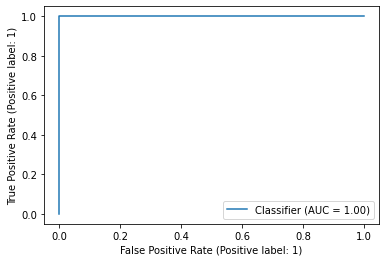

In [23]:
dt_cf = DecisionTreeClassifier()
dt_cf.fit(X_train_f, y_train_f)
y_pred_f = dt_cf.predict_proba(X_train_f)[:,1]
auc_train_f = roc_auc_score(y_train_f, y_pred_f)
cv_res = cross_validate(estimator=dt_cf, X=X_train_f, y=y_train_f, cv=5, scoring='roc_auc_ovr', n_jobs= -1)
print(cv_res)
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [dt_cf, auc_train_f, auc_cv]

RocCurveDisplay.from_predictions(y_train_f, y_pred_f)
plt.show()

### Random Forest

In [17]:
rf_cf = RandomForestClassifier(random_state=42, n_jobs= -1)
rf_cf.fit(X_train_f, y_train_f)
y_pred_f = rf_cf.predict_proba(X_train_f)[:,1]
auc_train_f = roc_auc_score(y_train_f, y_pred_f)
cv_res = cross_validate(estimator=rf_cf, X=X_train_f, y=y_train_f, cv=5, scoring='roc_auc_ovr', n_jobs= -1)
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [rf_cf, auc_train_f, auc_cv]

RocCurveDisplay.from_predictions(y_train_f, y_pred_f)
plt.show()

### XG Boost

In [18]:
xgb_cf = XGBClassifier()
xgb_cf.fit(X_train_f, y_train_f)
y_pred_f = xgb_cf.predict_proba(X_train_f)[:,1]
auc_train = roc_auc_score(y_train_f, y_pred_f, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train_f, y=y_train_f, cv=5, scoring='roc_auc_ovr')
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = ['xgBoost', auc_train, auc_cv]

RocCurveDisplay.from_predictions(y_train_f, y_pred_f)
plt.show()

c:\Users\LordFabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:31] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\LordFabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\LordFabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:40] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\LordFabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:45] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\LordFabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\LordFabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:55:53] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [20]:
display(df_results)

,Model,AUC Train,AUC CV
0,"LogisticRegression(class_weight='balanced', ma...",0.922693,0.921730
1,DecisionTreeClassifier(),1.000000,0.817648
2,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.933843
3,xgBoost,0.969466,0.945306


In [20]:
knn_cf = KNeighborsClassifier(n_jobs= -1)
knn_cf.fit(X_train_f, y_train_f)
y_pred_F = knn_cf.predict_proba(X_train_f)
auc_train = roc_auc_score(y_train_f, y_pred_f)
cv_res = cross_validate(estimator=knn_cf, X=X_train_f, y=y_train_f, cv=5, scoring='roc_auc_ovr', n_jobs= -1)
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [knn_cf, auc_train, auc_cv]

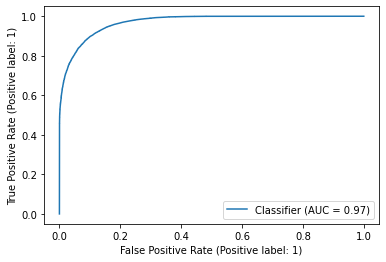

In [1]:
'''svm_cf = SVC(probability=True,cache_size= 3000)
svm_cf.fit(X_train_f, y_train_f)
y_pred_f = svm_cf.predict_proba(X_train_f)[:,1]
print(y_pred_f)
auc_train = roc_auc_score(y_train_f, y_pred_f)
cv_res = cross_validate(estimator=svm_cf, X=X_train_f, y=y_train_f, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
df_results.loc[len(df_results)] = [svm_cf, auc_train, auc_cv]'''

'svm_cf = SVC(probability=True,cache_size= 3000)\nsvm_cf.fit(X_train_f, y_train_f)\ny_pred_f = svm_cf.predict_proba(X_train_f)[:,1]\nprint(y_pred_f)\nauc_train = roc_auc_score(y_train_f, y_pred_f)\ncv_res = cross_validate(estimator=svm_cf, X=X_train_f, y=y_train_f, cv=5, scoring=\'roc_auc_ovr\', n_jobs=-1)\nauc_cv = cv_res["test_score"].mean()\ndf_results.loc[len(df_results)] = [svm_cf, auc_train, auc_cv]'

In [ ]:
display(df_results)

,Model,AUC Train,AUC CV
0,"LogisticRegression(max_iter=1000, solver='sag')",0.922546,0.921608
1,DecisionTreeClassifier(),1.000000,0.818375
2,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.933402
3,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.969466,0.945306
4,KNeighborsClassifier(),0.969466,0.899505


### Hyperparameter Tuning
<br>Logistische Regression, Random Forest und XGBoost sind besitzen die höchste Güte
<br>Modellgüte kann noch verbessert werden

In [ ]:
df_tuned = pd.DataFrame(data=[], columns=["Model", "AUC Train", "AUC CV"])

In [ ]:
param_grid = [{
    "n_estimators":[100, 500, 1000, 2000],
    "max_depth": [5, 10, 15, 20],
    "bootstrap": [True, False]
}]

rf_cf = RandomForestClassifier(random_state=42, n_jobs= -1)
rs = RandomizedSearchCV(rf_cf, param_distributions=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs= -1, n_iter = 5)
rs.fit(X_train_f, y_train_f)
best = rs.best_params_


In [ ]:
rf_cf = RandomForestClassifier(random_state=42, bootstrap = best.get('bootstrap'), max_depth = best.get('max_depth'), n_estimators =best.get('n_estimators'), n_jobs= -1)
rf_cf.fit(X_train_f, y_train_f)
y_pred_f = rf_cf.predict_proba(X_train_f)[:,1]
auc_train_f = roc_auc_score(y_train_f, y_pred_f)
cv_res = cross_validate(estimator=rf_cf, X=X_train_f, y=y_train_f, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()

df_tuned.loc[len(df_tuned)] = [rf_cf, auc_train_f, auc_cv]

### XGBoost

In [ ]:
param_grid = [{
    "eta":[0.01, 0.1,0.2,0.3],
    "max_depth": [3, 5, 6, 9],
    "min_child_weight": [0.5,1 ,2,5]
}]

xg_cf = XGBClassifier(random_state=42, n_jobs= -1)
rs = RandomizedSearchCV(xg_cf, param_distributions=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs= -1, n_iter = 5)
rs.fit(X_train_f, y_train_f)
best = rs.best_params_

c:\Users\LordFabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:17:18] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
xgb_cf = XGBClassifier(nthread=-1,eta=best.get('eta'), max_depth= best.get('max_depth'), min_child_weight= best.get('min_child_weight'),  n_jobs= -1)
xgb_cf.fit(X_train_f, y_train_f)
y_pred_f = xgb_cf.predict_proba(X_train_f)[:,1]
auc_train = roc_auc_score(y_train_f, y_pred_f, multi_class='ovr')
cv_res = cross_validate(estimator=xgb_cf, X=X_train_f, y=y_train_f, cv=5, scoring='roc_auc_ovr',  n_jobs= -1)
auc_cv = cv_res["test_score"].mean()
df_tuned.loc[len(df_results)] = [xgb_cf, auc_train, auc_cv]

c:\Users\LordFabi\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:20:26] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Support Vector Machine

In [ ]:
param_grid = [{
    "kernel":['poly', 'rbf', 'sigmoid', 'precomputed'],
    "coef0": [0.1, 0.5, 2],
    "shrinking": [True, False]
}]

svm_cf = SVC(probability=True,cache_size= 1000)
rs = RandomizedSearchCV(svm_cf, param_distributions=param_grid, scoring="roc_auc_ovr", cv=5, n_jobs= -1, n_iter = 5)
rs.fit(X_train_f, y_train_f)
best = rs.best_params_

In [ ]:
svm_cf = SVC(probability=True,cache_size= 1000, kernel=best.get('kernel'), coef0=best.get('coef0'), shrinking=best.get('shrinking'))
svm_cf.fit(X_train_f, y_train_f)
y_pred_f = svm_cf.predict_proba(X_train_f)[:,1]
auc_train = roc_auc_score(y_train_f, y_pred_f)
cv_res = cross_validate(estimator=svm_cf, X=X_train_f, y=y_train_f, cv=5, scoring='roc_auc_ovr', n_jobs=-1)
auc_cv = cv_res["test_score"].mean()
df_tuned.loc[len(df_results)] = [svm_cf, auc_train, auc_cv]


In [ ]:
display(df_tuned)
display(df_results)


,Model,AUC Train,AUC CV
0,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.997061,0.941102
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.949854,0.940852


,Model,AUC Train,AUC CV
0,"LogisticRegression(max_iter=1000, solver='sag')",0.922546,0.921608
1,DecisionTreeClassifier(),1.000000,0.816620
2,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.933402
3,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.969466,0.945306
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.949854,0.940852


In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_train_f, y_pred_f)
plt.show()
